In [103]:
import numpy as np
import pandas as pd
import csv
from itertools import islice
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
import torch.utils.data as Data
from torchsummary import summary
from  torch.optim import Adam 
from sklearn.linear_model import LinearRegression

In [ ]:
file = pd.read_excel("./1.xlsx")


In [ ]:
file

In [ ]:
#剔除无关变量的内容
file  =file.drop(['Name','Bib','Overall','Gender','Division'],axis = 1)


In [ ]:
file.isnull().sum() #各列缺失值情况(NAN)

# 但除了NA,部分特征的部分元素为-,因此这个也要统计,算作是缺失值

In [ ]:

def sta_(data):
    feature = data.columns
    a = {}
    for i in tqdm(feature):
        n = 0
        for m in data[i]:
            if m =="-":
                n+=1
        a[i] = n
    return a
sta_(file)

                



In [ ]:
file.to_csv("C:/Users/Hasee/Desktop/pth存放/删除无关变量.csv",index=False)

In [ ]:

#剔除缺失值数量过大的特征
file = file.drop(['Proj Time','State','Citizen'],axis=1)
file.to_csv("C:/Users/Hasee/Desktop/pth存放/删除缺失值数量过大.csv",index=False)


In [ ]:
file
#查看数据

In [ ]:

#性别进行二值化

for index,i in tqdm(enumerate (file['M/F'])):
    if i=='M':
        file.loc[index,'M/F']=1
    else:
        file.loc[index,'M/F']=0


#各分段成绩

In [ ]:
file.to_csv("C:/Users/Hasee/Desktop/pth存放/性别二元化后.csv",index=False)

In [ ]:
#对各分段成绩及最终成绩进行转换

def time_deal(time):

    temper = time.split(':')
    hour,minute,second = int(temper[0]),int(temper[1]),int(temper[2])

    total_time = total_minute = hour * 60 + minute + second / 60
    return float(round(total_minute, 3))

#对各区间成绩进行类型转换
file['5K'] = file['5K'].astype(str)
file['10K'] = file['10K'].astype(str)
file['15K'] = file['15K'].astype(str)
file['20K'] = file['20K'].astype(str)
file['Half'] = file['Half'].astype(str)
file['25K'] = file['25K'].astype(str)
file['30K'] = file['30K'].astype(str)
file['35K'] = file['35K'].astype(str)
file['40K'] = file['40K'].astype(str)

file['Official Time'] = file['Official Time'].astype(str)

score = ['5K','10K','15K','20K','Half','25K','30K','35K','40K','Official Time']
for i in tqdm (score): #对每一列进行遍历
    for index,m in enumerate(file[i]): #对每一列的每一个元素进行遍历
        if m=='-':
            continue
        else:
            file[i][index] = time_deal(m)


In [ ]:
#上面脚本模型奇妙会报错,运行一下下面的脚本就OK
#如果#对各分段成绩及最终成绩进行转换这一步报错,就在这里手动改一下格式
for index, i in enumerate (file['Official Time']):
    if type(i)!=float:
        print(file['Official Time'][index-5])
        file['Official Time'][index] = 178.983
        break
        
        

for index, i in enumerate (file['Official Time']):
    if type(i)==str:
        file['Official Time'][index]= time_deal(i)


In [ ]:
file['Pace'] = file['Pace'].astype(str)
for index, i in enumerate (file['Pace']):
        file['Pace'][index]= time_deal(i)

In [ ]:
print(file)
file.to_csv("C:/Users/Hasee/Desktop/pth存放/成绩格式化.csv",index=False)
#查看数据

In [104]:
file = pd.read_csv("C:/Users/Hasee/Desktop/pth存放/成绩格式化.csv")

In [105]:
file = file.replace('-',np.nan)

In [106]:
file

Age  M/F          City Country      5K     10K      15K      20K  \
0       25    1          Ambo     ETH  14.717  29.717    44.95   60.483   
1       30    1   Addis Ababa     ETH  14.717  29.717   44.967   60.467   
2       29    1      Marakwet     KEN  14.717  29.717    44.95   60.483   
3       28    1       Eldoret     KEN  14.717  29.733   45.017   60.483   
4       32    1        Kitale     KEN  14.717  29.733   44.967   60.467   
...    ...  ...           ...     ...     ...     ...      ...      ...   
79633   61    0       Ontario     USA  46.733  95.683  143.583  192.733   
79634   25    1  Fayetteville     USA   32.05   65.55  112.283  169.683   
79635   57    0       Malvern     USA  53.183   103.6    152.6      NaN   
79636   64    1      New York     USA  40.567  87.317  137.283  191.667   
79637   48    1    Alpharetta     USA    39.6    77.2  120.167  178.917   

          Half      25K      30K      35K      40K    Pace  Official Time  
0       64.033   76.117     92.0  107.983   122.65   4.933        129.283  
1       64.017   76.117   91.983  107.983    122.7   4.967        129.800  
2       64.033   76.117     92.0  107.983  123.017   4.983        130.367  
3       64.033   76.117     92.0   108.05  123.783   5.000        130.783  
4       64.017   76.117     92.0  107.983   123.45   5.000        130.817  
...        ...      ...      ...      ...      ...     ...            ...  
79633  203.517    252.1  303.133    355.3   406.95  16.400        429.650  
79634  180.433  230.317  290.017    353.8   414.35  16.667        436.983  
79635    216.4   255.35  306.617   360.55  414.633  16.783        439.617  
79636    202.5  246.167   307.15  366.117  416.133  16.817        440.733  
79637  188.267  267.233  337.217  399.117  461.383  18.250        478.233  

[79638 rows x 15 columns]

In [107]:
#缺失值填充
def filled(datas,style):
    features = ['5K','10K','15K','20K','Half','25K','30K','35K','40K','Pace','Official Time']
    for m in features:
        datas[m] = datas[m].astype(float)
    if style == 'average':
        for i in features:
            datas[i].fillna(datas[i].mean(),inplace=True)
    elif style == 'mid':
        for i in features:
            datas[i].fillna(datas[i].median(),inplace = True)
    return datas
file = filled(file,'average')






    

In [108]:


# mask = file.notnull().all(axis=1)
# rows_without_missing_values = file[mask]
# rows_without_missing_values



In [109]:

# mask1 = file.isnull().any(axis=1)
# rows_only_missing_values = file[mask1]
# mask2 =rows_only_missing_values['5K'].isnull()
# rows_missing_values = rows_only_missing_values[mask2]
# rows_missing_values
# pred_x = rows_missing_values.drop(['5K','City','Country'],axis=1)
# for index, row  in pred_x.iterrows():
#     row_2 = row.dropna()
#     pred_y = model.predict(row_2)
#     rows_missing_values['5k'][index] = pred_y

In [110]:
# #自适应回归插补
# import warnings
# warnings.filterwarnings('ignore')
# features = ['5K','10K','15K','20K','Half','25K','30K','35K','40K','Pace','Official Time']
# for index,i in tqdm(enumerate (features)):
#     #i代表的是要预测的特征
#     #那非缺失数据训练模型
#     # mask_x_data = rows_without_missing_values.drop([i,'City','Country'],axis=1)
#     # mask_y_data = rows_without_missing_values[i]
    
#     # mask_train_x,mask_val_x,mask_train_y,mask_val_y = train_test_split(mask_x_data,mask_y_data,test_size=0.3)
#     # model = LinearRegression() 
#     # model.fit(mask_train_x,mask_train_y)
#     #取存在缺失数据预测缺失值
#     mask1 = file.isnull().any(axis=1)
#     rows_only_missing_values = file[mask1]
#     mask2 =rows_only_missing_values[i].isnull()
#     rows_missing_values = rows_only_missing_values[mask2]
#     pred_x = rows_missing_values.drop([i,'City','Country'],axis=1)
#     # print(pred_x)
#     #用于预测的,但是pred_X里存在缺失值,因此建立自适应机制,对每一个样本进行遍历,存在缺失值,就对该样本对应特征进行删除
#     for index, row  in pred_x.iterrows():
#         # print(index)
#         #这个是单纯的只有每一行的数据
#         row_2 = row.dropna()
#         col_names = row_2.index.tolist()
#         # print(col_names)
#         mask_x_data = rows_without_missing_values[col_names]#自适应无缺数据_x
#         # print(mask_x_data.columns)
#         mask_y_data = rows_without_missing_values[i] #自适应无缺数据_y
#         model = LinearRegression() 
#         model.fit(mask_x_data,mask_y_data)
#         row_2 = np.array(row_2).reshape(1,-1)
#         pred_y = model.predict(row_2)
#         pred_y = round(float(pred_y),3)
#         #将pred_y填充进原始数据中
#         file[i][index] = pred_y
    
    

    
    
    






In [111]:
# #自适应近邻回归插补
# import warnings
# warnings.filterwarnings('ignore')
# features = ['5K','10K','15K','20K','Half','25K','30K','35K','40K','Pace','Official Time']
# for index,i in tqdm(enumerate (features)):
#     #取存在缺失数据预测缺失值
#     mask1 = file.isnull().any(axis=1)
#     rows_only_missing_values = file[mask1]
#     mask2 =rows_only_missing_values[i].isnull()
#     rows_missing_values = rows_only_missing_values[mask2]
#     pred_x = rows_missing_values.drop([i,'City','Country'],axis=1)
#     #用于预测的,但是pred_X里存在缺失值,因此建立自适应机制,对每一个样本进行遍历,存在缺失值,就对该样本对应特征进行删除
#     for index, row  in pred_x.iterrows():
#         #这个是单纯的只有每一行的数据
#         row_2 = row.dropna()
#         #在这里要增加一个对数据来说更近的
#         col_names = row_2.index.tolist()
#         # print(col_names)
#         mask_x_data = rows_without_missing_values[col_names]#自适应无缺数据_x
#         # print(mask_x_data.columns)
#         mask_y_data = rows_without_missing_values[i] #自适应无缺数据_y
#         model = LinearRegression() 
#         model.fit(mask_x_data,mask_y_data)
#         row_2 = np.array(row_2).reshape(1,-1)
#         pred_y = model.predict(row_2)
#         print(pred_y)
#         #将pred_y填充进原始数据中
#         # file[i][index] = pred_y
    

In [112]:
file.isnull().sum()

Age              0
M/F              0
City             1
Country          0
5K               0
10K              0
15K              0
20K              0
Half             0
25K              0
30K              0
35K              0
40K              0
Pace             0
Official Time    0
dtype: int64

In [113]:
file

Age  M/F          City Country      5K      10K      15K         20K  \
0       25    1          Ambo     ETH  14.717   29.717   44.950   60.483000   
1       30    1   Addis Ababa     ETH  14.717   29.717   44.967   60.467000   
2       29    1      Marakwet     KEN  14.717   29.717   44.950   60.483000   
3       28    1       Eldoret     KEN  14.717   29.733   45.017   60.483000   
4       32    1        Kitale     KEN  14.717   29.733   44.967   60.467000   
...    ...  ...           ...     ...     ...      ...      ...         ...   
79633   61    0       Ontario     USA  46.733   95.683  143.583  192.733000   
79634   25    1  Fayetteville     USA  32.050   65.550  112.283  169.683000   
79635   57    0       Malvern     USA  53.183  103.600  152.600  103.558546   
79636   64    1      New York     USA  40.567   87.317  137.283  191.667000   
79637   48    1    Alpharetta     USA  39.600   77.200  120.167  178.917000   

          Half      25K      30K      35K      40K    Pace  Official Time  
0       64.033   76.117   92.000  107.983  122.650   4.933        129.283  
1       64.017   76.117   91.983  107.983  122.700   4.967        129.800  
2       64.033   76.117   92.000  107.983  123.017   4.983        130.367  
3       64.033   76.117   92.000  108.050  123.783   5.000        130.783  
4       64.017   76.117   92.000  107.983  123.450   5.000        130.817  
...        ...      ...      ...      ...      ...     ...            ...  
79633  203.517  252.100  303.133  355.300  406.950  16.400        429.650  
79634  180.433  230.317  290.017  353.800  414.350  16.667        436.983  
79635  216.400  255.350  306.617  360.550  414.633  16.783        439.617  
79636  202.500  246.167  307.150  366.117  416.133  16.817        440.733  
79637  188.267  267.233  337.217  399.117  461.383  18.250        478.233  

[79638 rows x 15 columns]

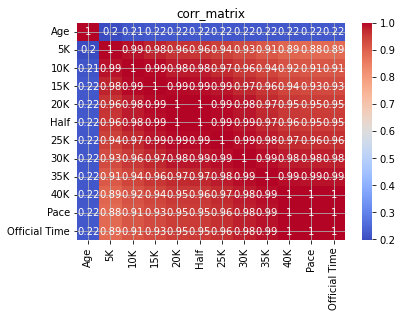

In [114]:
#查看相关矩阵(连续)
corr_matrix = file.drop(['M/F','City','Country'],axis=1).corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.grid()
plt.title('corr_matrix')
plt.savefig('C:/Users/Hasee/Desktop/img_save/corr_matrix.png')
plt.show()












In [115]:
#剔除共线性高特征
file = file.drop(['Pace','40K','20K'],axis=1)

In [116]:
file

Age  M/F          City Country      5K      10K      15K     Half  \
0       25    1          Ambo     ETH  14.717   29.717   44.950   64.033   
1       30    1   Addis Ababa     ETH  14.717   29.717   44.967   64.017   
2       29    1      Marakwet     KEN  14.717   29.717   44.950   64.033   
3       28    1       Eldoret     KEN  14.717   29.733   45.017   64.033   
4       32    1        Kitale     KEN  14.717   29.733   44.967   64.017   
...    ...  ...           ...     ...     ...      ...      ...      ...   
79633   61    0       Ontario     USA  46.733   95.683  143.583  203.517   
79634   25    1  Fayetteville     USA  32.050   65.550  112.283  180.433   
79635   57    0       Malvern     USA  53.183  103.600  152.600  216.400   
79636   64    1      New York     USA  40.567   87.317  137.283  202.500   
79637   48    1    Alpharetta     USA  39.600   77.200  120.167  188.267   

           25K      30K      35K  Official Time  
0       76.117   92.000  107.983        129.283  
1       76.117   91.983  107.983        129.800  
2       76.117   92.000  107.983        130.367  
3       76.117   92.000  108.050        130.783  
4       76.117   92.000  107.983        130.817  
...        ...      ...      ...            ...  
79633  252.100  303.133  355.300        429.650  
79634  230.317  290.017  353.800        436.983  
79635  255.350  306.617  360.550        439.617  
79636  246.167  307.150  366.117        440.733  
79637  267.233  337.217  399.117        478.233  

[79638 rows x 12 columns]

In [117]:
file[['Age','M/F','Official Time']]

Age  M/F  Official Time
0       25    1        129.283
1       30    1        129.800
2       29    1        130.367
3       28    1        130.783
4       32    1        130.817
...    ...  ...            ...
79633   61    0        429.650
79634   25    1        436.983
79635   57    0        439.617
79636   64    1        440.733
79637   48    1        478.233

[79638 rows x 3 columns]

In [118]:

#考虑降维
pca = PCA(n_components=1)
X_pca = pca.fit_transform(file.drop(['Age','M/F','Official Time','City','Country'],axis=1))
file_combined =  np.hstack((X_pca, file[['Age','M/F','Official Time','City','Country']]))


In [119]:
file_combined = pd.DataFrame(file_combined)

In [120]:
file_combined

0   1  2        3             4    5
0     -134.135979  25  1  129.283          Ambo  ETH
1     -134.146217  30  1    129.8   Addis Ababa  ETH
2     -134.135979  29  1  130.367      Marakwet  KEN
3     -134.077198  28  1  130.783       Eldoret  KEN
4     -134.135189  32  1  130.817        Kitale  KEN
...           ...  .. ..      ...           ...  ...
79633  279.398124  61  0   429.65       Ontario  USA
79634  242.964067  25  1  436.983  Fayetteville  USA
79635  293.595918  57  0  439.617       Malvern  USA
79636  282.409713  64  1  440.733      New York  USA
79637  316.978318  48  1  478.233    Alpharetta  USA

[79638 rows x 6 columns]

In [121]:
columns = ['聚类特征','年龄','性别','预测指标','城市','国家']
file_combined.columns = columns

In [122]:
file_combined.to_csv('C:/Users/Hasee/Desktop/pth存放/主成分分析后.csv',index=False)

In [123]:
file_combined

聚类特征  年龄 性别     预测指标            城市   国家
0     -134.135979  25  1  129.283          Ambo  ETH
1     -134.146217  30  1    129.8   Addis Ababa  ETH
2     -134.135979  29  1  130.367      Marakwet  KEN
3     -134.077198  28  1  130.783       Eldoret  KEN
4     -134.135189  32  1  130.817        Kitale  KEN
...           ...  .. ..      ...           ...  ...
79633  279.398124  61  0   429.65       Ontario  USA
79634  242.964067  25  1  436.983  Fayetteville  USA
79635  293.595918  57  0  439.617       Malvern  USA
79636  282.409713  64  1  440.733      New York  USA
79637  316.978318  48  1  478.233    Alpharetta  USA

[79638 rows x 6 columns]

In [124]:
#查看离散变量的类别数量
print(file_combined['性别'].nunique())
print(file_combined['国家'].nunique())
print(file_combined['城市'].nunique())
#删除city特征
file_combined = file_combined.drop(['城市'],axis=1)

2
105
9823


In [125]:
#哑变量编码
file_dummy =pd.get_dummies(data=file_combined,columns=['国家'])

In [126]:
file_dummy

聚类特征  年龄 性别     预测指标  国家_AHO  国家_ALB  国家_ALG  国家_AND  国家_ARG  \
0     -134.135979  25  1  129.283       0       0       0       0       0   
1     -134.146217  30  1    129.8       0       0       0       0       0   
2     -134.135979  29  1  130.367       0       0       0       0       0   
3     -134.077198  28  1  130.783       0       0       0       0       0   
4     -134.135189  32  1  130.817       0       0       0       0       0   
...           ...  .. ..      ...     ...     ...     ...     ...     ...   
79633  279.398124  61  0   429.65       0       0       0       0       0   
79634  242.964067  25  1  436.983       0       0       0       0       0   
79635  293.595918  57  0  439.617       0       0       0       0       0   
79636  282.409713  64  1  440.733       0       0       0       0       0   
79637  316.978318  48  1  478.233       0       0       0       0       0   

       国家_AUS  ...  国家_TWN  国家_UAE  国家_UGA  国家_UKR  国家_URU  国家_USA  国家_VEN  \
0           0  ...       0       0       0       0       0       0       0   
1           0  ...       0       0       0       0       0       0       0   
2           0  ...       0       0       0       0       0       0       0   
3           0  ...       0       0       0       0       0       0       0   
4           0  ...       0       0       0       0       0       0       0   
...       ...  ...     ...     ...     ...     ...     ...     ...     ...   
79633       0  ...       0       0       0       0       0       1       0   
79634       0  ...       0       0       0       0       0       1       0   
79635       0  ...       0       0       0       0       0       1       0   
79636       0  ...       0       0       0       0       0       1       0   
79637       0  ...       0       0       0       0       0       1       0   

       国家_VGB  国家_VIE  国家_ZIM  
0           0       0       0  
1           0       0       0  
2           0       0       0  
3           0       0       0  
4           0       0       0  
...       ...     ...     ...  
79633       0       0       0  
79634       0       0       0  
79635       0       0       0  
79636       0       0       0  
79637       0       0       0  

[79638 rows x 109 columns]

In [127]:

file_dummy.to_csv("C:/Users/Hasee/Desktop/哑变量编码后.csv",index=False)

In [128]:
file_dummy


聚类特征  年龄 性别     预测指标  国家_AHO  国家_ALB  国家_ALG  国家_AND  国家_ARG  \
0     -134.135979  25  1  129.283       0       0       0       0       0   
1     -134.146217  30  1    129.8       0       0       0       0       0   
2     -134.135979  29  1  130.367       0       0       0       0       0   
3     -134.077198  28  1  130.783       0       0       0       0       0   
4     -134.135189  32  1  130.817       0       0       0       0       0   
...           ...  .. ..      ...     ...     ...     ...     ...     ...   
79633  279.398124  61  0   429.65       0       0       0       0       0   
79634  242.964067  25  1  436.983       0       0       0       0       0   
79635  293.595918  57  0  439.617       0       0       0       0       0   
79636  282.409713  64  1  440.733       0       0       0       0       0   
79637  316.978318  48  1  478.233       0       0       0       0       0   

       国家_AUS  ...  国家_TWN  国家_UAE  国家_UGA  国家_UKR  国家_URU  国家_USA  国家_VEN  \
0           0  ...       0       0       0       0       0       0       0   
1           0  ...       0       0       0       0       0       0       0   
2           0  ...       0       0       0       0       0       0       0   
3           0  ...       0       0       0       0       0       0       0   
4           0  ...       0       0       0       0       0       0       0   
...       ...  ...     ...     ...     ...     ...     ...     ...     ...   
79633       0  ...       0       0       0       0       0       1       0   
79634       0  ...       0       0       0       0       0       1       0   
79635       0  ...       0       0       0       0       0       1       0   
79636       0  ...       0       0       0       0       0       1       0   
79637       0  ...       0       0       0       0       0       1       0   

       国家_VGB  国家_VIE  国家_ZIM  
0           0       0       0  
1           0       0       0  
2           0       0       0  
3           0       0       0  
4           0       0       0  
...       ...     ...     ...  
79633       0       0       0  
79634       0       0       0  
79635       0       0       0  
79636       0       0       0  
79637       0       0       0  

[79638 rows x 109 columns]

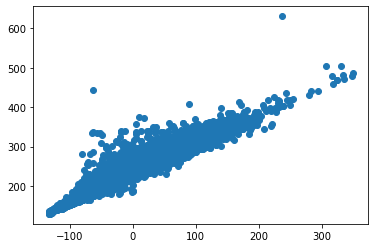

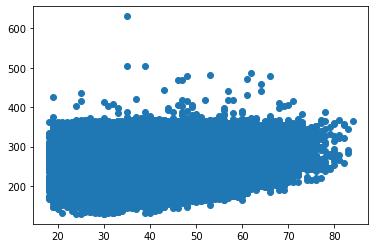

In [129]:
#查看连续型变量的分布情况
plt.scatter(file_dummy['聚类特征'],file_dummy['预测指标'])
plt.show()
plt.scatter(file_dummy['年龄'],file_dummy['预测指标'])
plt.show()



In [130]:
#数据标准化(这一步一定要在数据填充之前)
 
contin = []
continuous = ['聚类特征','年龄']
# df =file[['Age'],['5K'],['10K'],['15K'],['20K'],['Half'],['25K'],['30K'],['35K'],['40K']]
scaler =  StandardScaler()
#对均值填充标准化
for i in continuous:
    file_dummy[i] = scaler.fit_transform(np.array(file_dummy[i]).reshape(-1,1))
#中位数填充标准化
    file_dummy[i] = scaler.fit_transform(np.array(file_dummy[i]).reshape(-1,1))
file_dummy.to_csv('D:/from Junior to now_sun/this is all/ai/model/体育项目数据挖掘/均值标准化.csv',index=False)








In [131]:
#查看数据
file_dummy.isnull().sum()

聚类特征      0
年龄        0
性别        0
预测指标      0
国家_AHO    0
         ..
国家_USA    0
国家_VEN    0
国家_VGB    0
国家_VIE    0
国家_ZIM    0
Length: 109, dtype: int64

In [132]:
file_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79638 entries, 0 to 79637
Columns: 109 entries, 聚类特征 to 国家_ZIM
dtypes: float64(2), object(2), uint8(105)
memory usage: 10.4+ MB


In [133]:
file_dummy

聚类特征        年龄 性别     预测指标  国家_AHO  国家_ALB  国家_ALG  国家_AND  国家_ARG  \
0     -2.483477 -1.533649  1  129.283       0       0       0       0       0   
1     -2.483667 -1.093329  1    129.8       0       0       0       0       0   
2     -2.483477 -1.181393  1  130.367       0       0       0       0       0   
3     -2.482389 -1.269457  1  130.783       0       0       0       0       0   
4     -2.483463 -0.917201  1  130.817       0       0       0       0       0   
...         ...       ... ..      ...     ...     ...     ...     ...     ...   
79633  5.172951  1.636654  0   429.65       0       0       0       0       0   
79634  4.498388 -1.533649  1  436.983       0       0       0       0       0   
79635  5.435818  1.284398  0  439.617       0       0       0       0       0   
79636  5.228710  1.900846  1  440.733       0       0       0       0       0   
79637  5.868735  0.491823  1  478.233       0       0       0       0       0   

       国家_AUS  ...  国家_TWN  国家_UAE  国家_UGA  国家_UKR  国家_URU  国家_USA  国家_VEN  \
0           0  ...       0       0       0       0       0       0       0   
1           0  ...       0       0       0       0       0       0       0   
2           0  ...       0       0       0       0       0       0       0   
3           0  ...       0       0       0       0       0       0       0   
4           0  ...       0       0       0       0       0       0       0   
...       ...  ...     ...     ...     ...     ...     ...     ...     ...   
79633       0  ...       0       0       0       0       0       1       0   
79634       0  ...       0       0       0       0       0       1       0   
79635       0  ...       0       0       0       0       0       1       0   
79636       0  ...       0       0       0       0       0       1       0   
79637       0  ...       0       0       0       0       0       1       0   

       国家_VGB  国家_VIE  国家_ZIM  
0           0       0       0  
1           0       0       0  
2           0       0       0  
3           0       0       0  
4           0       0       0  
...       ...     ...     ...  
79633       0       0       0  
79634       0       0       0  
79635       0       0       0  
79636       0       0       0  
79637       0       0       0  

[79638 rows x 109 columns]

In [134]:
#数据划分

file = pd.read_csv('D:/from Junior to now_sun/this is all/ai/model/体育项目数据挖掘/均值标准化.csv')


def split(data):
    y_data = data['预测指标']
    x_data = data.drop(['预测指标'],axis=1)
    X_train_val, X_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    #x_train,x_val,x_test分别表示训练,验证,测试
    return X_train, y_train,X_val, y_val,X_test,y_test





In [135]:
#因为csv格式,所以有逗号,所以读取后,pandas认为第一行存在空列并且有,所以生成unnamed

In [136]:

class mydataloader(torch.utils.data.Dataset):
    def __init__(self,data,label):
        super().__init__()
        self.data=np.array(data)
        self.label=np.array(label)
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        return self.data[index],self.label[index]
X_train, y_train,X_val, y_val,X_test,y_test = split(file) 
train_set=mydataloader(X_train, y_train)
val_set=mydataloader(X_val, y_val)
test_set=mydataloader(X_test,y_test)
batch_size = 256
train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_set,batch_size=batch_size)
test_loader=DataLoader(test_set,batch_size=batch_size)




In [137]:
#建立神经网络模型

# class mymodel(nn.Module):
#     def __init__(self,init_weight=False):
#         super().__init__()
#         self.linear=nn.Sequential(
#             nn.Linear(108,20),
#             nn.Sigmoid(),
#             nn.Linear(20,10),
#             nn.Sigmoid(),
#             nn.Linear(10,6),
#             nn.Sigmoid(),
#             nn.Linear(6,1)

#         )
#         if init_weight==True:
#             self._initialize_weight()

#     def forward(self,x):
#         # x=torch.reshape(x,(1,))
#         x=self.linear(x)
#         return x
        
#     def _initialize_weight(self):
#         for m in self.modules():
#             if isinstance(m,nn.Linear):
#                 nn.init.normal_(m.weight,0,1)
#                 nn.init.constant_(m.bias,0.01)
# ##开始训练


# model = mymodel()
# # summary(model.cuda(),(79999,116))
device='cuda' if torch.cuda.is_available() else 'cpu'

In [138]:
#全连接残差自注意力网络
class mymodel(nn.Module):
    def __init__(self,init_weight=False):
        super().__init__()
        self.ln1 = nn.Linear(108,20)
        self.reln1 = nn.Linear(108,20)
        self.act = nn.Sigmoid()
        self.ln2 = nn.Linear(20,10)
        self.reln2 = nn.Linear(20,10)


        self.ln3 = nn.Linear(10,6)
        self.reln3 = nn.Linear(10,6)
        self.at = nn.Linear(10,6)
        self.ln4 = nn.Linear(6,1)


        if init_weight==True:
            self._initialize_weight()

    def forward(self,x):
        residual1 = x #106
        x = self.ln1(x) #20
        x = self.act(x)
        residual1 = self.reln1(residual1) #20

        x = x+residual1 #20
        residual2 = x #20
        x = self.act(self.ln2(x)) #10
        residual2 = self.reln2(residual2) #10
        x = x+residual2 #10
        residual3 = x #10
        attention = x
        x =self.act(self.ln3(x)) #6
        residual3 = self.reln3(residual3)#6
        attention = self.act(self.at(attention))
    
        x = x+residual3 #6

        x = x*attention
     
        x =self.ln4(x) #2
        

        return x
        
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,0,1)
                nn.init.constant_(m.bias,0.01)
# model = mymodel()
# summary(model.cuda(),(256,108))
# model

In [139]:

# #全连接残差网络
# class mymodel(nn.Module):
#     def __init__(self,init_weight=False):
#         super().__init__()
#         self.ln1 = nn.Linear(108,20)
#         self.reln1 = nn.Linear(108,20)
#         self.act = nn.Sigmoid()
#         self.ln2 = nn.Linear(20,10)
#         self.reln2 = nn.Linear(20,10)


#         self.ln3 = nn.Linear(10,6)
#         self.reln3 = nn.Linear(10,6)
#         self.ln4 = nn.Linear(6,1)


#         if init_weight==True:
#             self._initialize_weight()

#     def forward(self,x):
#         residual1 = x #106
#         x = self.ln1(x) #20
#         x = self.act(x)
#         residual1 = self.reln1(residual1) #20

#         x = x+residual1 #20
#         residual2 = x #20
#         x = self.act(self.ln2(x)) #10
#         residual2 = self.reln2(residual2) #10
#         x = x+residual2 #10
#         residual3 = x #10
#         x =self.act(self.ln3(x)) #6
#         residual3 = self.reln3(residual3)#6
#         x = x+residual3 #6
#         x =self.ln4(x) #2
        

#         return x
        
#     def _initialize_weight(self):
#         for m in self.modules():
#             if isinstance(m,nn.Linear):
#                 nn.init.normal_(m.weight,0,1)
#                 nn.init.constant_(m.bias,0.01)
# model = mymodel()
# summary(model.cuda(),(256,108))

In [140]:
#训练脚本
import torch.optim as optim
import  matplotlib.pyplot as plt
import seaborn
net= mymodel (init_weight = True)
optimizer = Adam(net.parameters(),lr=0.01,weight_decay=0) 
# lambad = lambda epoch:0.00001 if epoch <5 else  ((1/(1+e**-epoch))/(18*epoch)*2)-0.0005
# lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,lr_lambda=lambad)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1) 
standard=nn.MSELoss()
X_train, y_train,X_val, y_val,X_test,y_test = split(file) 
plt_r2_val,plt_r2_test,plt_epoch = [],[],[]

best_mse = 0
epochs=150

print('device is {}'.format(device))
net.to(device)
for epoch in range(epochs):
    mse = 0
    running_loss=0.0
    net.train()

    print(f'----------epoch:{epoch+1}----------')
    for step,data in enumerate(train_loader):
        optimizer.zero_grad()
        train_x,train_y=data[0],data[1]

        train_x = torch.as_tensor(train_x,dtype=torch.float32)
        train_y = torch.as_tensor(train_y,dtype=torch.float32)

        output=net(train_x.to(device))

        loss=standard(output.to(device),train_y.unsqueeze(1).to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print('\r epoch:{},processing:{}/{}'.format(epoch,step+1,len(train_loader)),end=" ")
    lr_scheduler.step()
    net.eval()
    with torch.no_grad():
        list_y=[]
        y_pred =[]
        pd_y = pd.DataFrame()
        pd_pred = pd.DataFrame()
        pd_y_test = pd.DataFrame()
        pd_y_pred = pd.DataFrame()
        total_mse=0
        total_mae = 0
        total_mse_test=0
        total_mae_test = 0
        for data_v in val_loader:
            test_x,test_y=data_v[0],data_v[1]
            test_x,test_y = torch.as_tensor(test_x,dtype=torch.float32),torch.as_tensor(test_y,dtype=torch.float32)
            predict =net(test_x.to(device))
            predict = predict.view(-1)
            test_y = pd.Series(test_y)
            predict = pd.Series(predict)

            pd_y  =pd.concat([pd_y,test_y],axis=0)
            pd_pred = pd.concat([pd_pred,predict],axis=0)
            mse = mean_squared_error(test_y,predict)
            mae = mean_absolute_error(test_y,predict)
            #这个就是预测值和真实的平方差
            total_mse +=mse
            total_mae +=mae
        print(pd_y,pd_pred)
        pd_y  = np.array(pd_y)
        pd_pred = np.array(pd_pred)
        r2_val = r2_score(pd_pred,pd_y)
       
        rmse = np.sqrt(total_mse)
        if r2_val>best_mse:
            best_mse = r2_val
            torch.save(net.state_dict(), 'C:\\Users\\Hasee\\Desktop\\pth存放\\{}.pth'.format(epoch))
        for data_test in test_loader:
            val_x,val_y=data_v[0],data_v[1]
            val_x,val_y = torch.as_tensor(val_x,dtype=torch.float32,device=device),torch.as_tensor(val_y,dtype=torch.float32,device=device)
            predict =net(val_x)
            predict = predict.view(-1)
            test_y = pd.Series(val_y)
            predict = pd.Series(predict)

            pd_y_test  =pd.concat([pd_y_test,test_y],axis=0)
            pd_y_pred = pd.concat([pd_y_pred,predict],axis=0)
            mse = mean_squared_error(test_y,predict)
            mae = mean_absolute_error(test_y,predict)
            #这个就是预测值和真实的平方差
            total_mse_test +=mse
            total_mae_test +=mae
            # print(pd_y,pd_pred)
        pd_y_test  = np.array(pd_y_test)
        pd_y_pred = np.array(pd_y_pred)
        r2_test = r2_score(pd_y_pred,pd_y_test)
        print("epoch:{},val_r2:{},val_mse:{},model_lr:{},test_r2:{}".format(epoch+1,r2_val,total_mse,optimizer.param_groups[0]['lr'],r2_test))
        plt_r2_val.append(r2_val)
        plt_r2_test.append(r2_test)

         


device is cuda
----------epoch:1----------
torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:1/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:2/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:3/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:4/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:5/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:6/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:7/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:8/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:9/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:10/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:11/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:12/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:13/210 torch.Size([256, 6])
torch.Size([256, 6])
 epoch:0,processing:14/210 

In [ ]:
for index,i in enumerate (plt_r2_val):
    if i<0:
        plt_r2_val[index]=0
for index,i in enumerate (plt_r2_test):
    if i<0:
        plt_r2_test[index]=0



plt.plot(plt_r2_val)
plt.grid()
plt.ylabel('val_r2')
plt.xlabel('epoch')
plt.title('fill_average_val')
plt.savefig('C:/Users/Hasee/Desktop/img_save/attention_average_val_r2.png')
plt.show()

plt.plot(plt_r2_test)
plt.grid()
plt.ylabel('test_r2')
plt.xlabel('epoch')
plt.title('fill_average_test')
plt.savefig('C:/Users/Hasee/Desktop/img_save/attention_average_test_r2.png')
plt.show()
         